In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

## Define model

In [66]:
def dz_dt(z, t, beta, gamma, N):
    """
    Susceptible-Infectious (SIS) model.

    Args:
        beta: Infection rate (transmission rate).
        gamma: Recovery rate.

    Returns:
        S, I, R : Arrays representing the number of susceptible, infected, and recovered individuals
                 at each time step.
    """
    # Initial conditions
    S = z[0]
    I = z[1]
    R = z[2]

    dS_dt = -beta * I * S / N;
    dI_dt =  beta * I * S / N - gamma * I;
    dR_dt =  gamma * I;

    return jnp.stack([dS_dt, dI_dt, dR_dt])

In [122]:
def model(num_days, z_init=None, beta=None, gamma=None, N=1000, n_states=3, observed_data=None):
    """
    :param int num_days: number of measurement times
    :param numpy.ndarray y: measured populations with shape (num_days, n_states)
    """

    # initial population
    if z_init == None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))

    # measurement times
    ts = jnp.arange(float(num_days))

    # parameters beta, gamma of dz_dt
    if beta == None:
        beta = numpyro.sample("beta", dist.TruncatedNormal(loc=0.6,scale=0.9,low=0.))

    if gamma == None:
        gamma = numpyro.sample("gamma", dist.TruncatedNormal(loc=0.1,scale=0.2,low=0.))

    # integrate dz/dt, the result will have shape num_days x 2
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, ts, beta, gamma, N, rtol=1e-6, atol=1e-5, mxstep=1000))

    # Likelihood
    numpyro.sample("observed", dist.Poisson(z[:, 1]), obs=observed_data)

## Simulate one sample

In [123]:
#beta_true = 0.1
#gamma_true = 0.5

N =1000
num_days = 100

z_init = jnp.array([N - 1.0, 1.0, 0.0])


In [124]:
sir_predictive = Predictive(model, num_samples=1)

rng_key_draw = PRNGKey(10)

sir_sim = sir_predictive(rng_key=rng_key_draw,
         num_days = num_days,
         z_init = z_init,
         N = N)

In [125]:
z = sir_sim['z'][0,:,:]
sim_observations = sir_sim['observed'][0,:]

print("beta = {}".format(sir_sim['beta']))
print("gamma = {}".format(sir_sim['gamma']))

beta = [1.4993744]
gamma = [0.2150667]


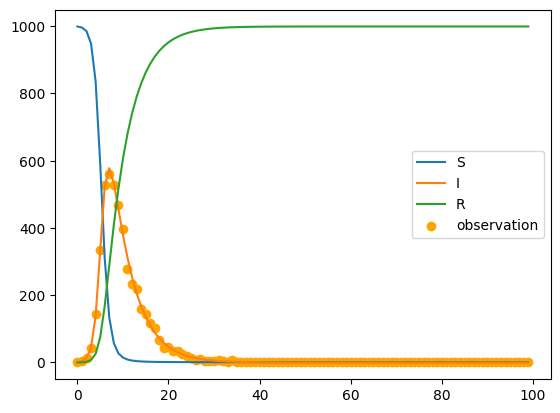

In [126]:
plt.plot(range(z.shape[0]), z[:,0], label='S')
plt.plot(range(z.shape[0]), z[:,1], label='I')
plt.plot(range(z.shape[0]), z[:,2], label='R')
plt.scatter(range(z.shape[0]), sim_observations, label='observation', color='orange')
plt.legend()

## Prior predictive

In [127]:
sir_predictive = Predictive(model, num_samples=110)

rng_key_draw = PRNGKey(11)

sir_sims = sir_predictive(rng_key=rng_key_draw,
         num_days = num_days,
         z_init = z_init,
         N = N)

In [128]:
sir_sims['z'].shape

(110, 100, 3)

In [129]:
z_prior_pred = sir_sims['z']

In [130]:
z_prior_mean = z_prior_pred.mean(axis=0)
z_prior_25 = np.quantile(z_prior_pred, 0.25, axis=0)
z_prior_75 = np.quantile(z_prior_pred, 0.75, axis=0)

In [131]:
ntimes = z_prior_mean.shape[0]

In [132]:
z_prior_mean.shape

(100, 3)

In [133]:
z_prior_pred.shape

(110, 100, 3)

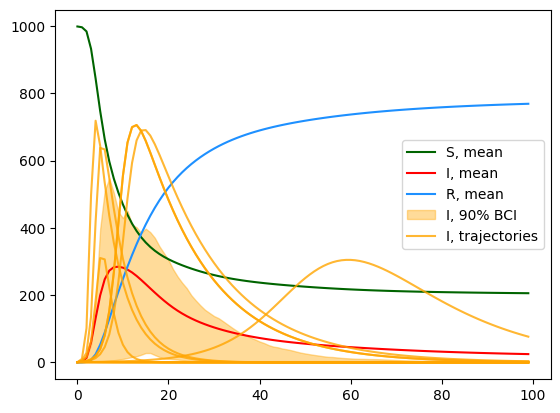

In [134]:
N_lines = 10

plt.plot(range(ntimes), z_prior_mean[:,0], label="S, mean", color="darkgreen")
plt.plot(range(ntimes), z_prior_mean[:,1], label="I, mean", color= "red")
plt.plot(range(ntimes), z_prior_mean[:,2], label="R, mean", color= "dodgerblue")

plt.fill_between(range(ntimes), z_prior_25[:, 1], z_prior_75[:,1], alpha=0.4, interpolate=True, label="I, 90% BCI", color="orange")

for j in range(N_lines):
    itr = int(z_prior_pred.shape[0]/N_lines)
    if j == 0:
      plt.plot(range(ntimes), z_prior_pred[j* itr,:, 1], alpha=0.8, color="orange", label="I, trajectories")
    plt.plot(range(ntimes), z_prior_pred[j* itr,:, 1], alpha=0.8, color="orange", label="")

plt.legend()


In [ ]:
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")

plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")
#for j in range(N_lines):
#    itr = int(predictions_vae.shape[0]/N_lines)
#    plt.plot(x, predictions_vae[j* itr,:], alpha=0.2, color="darkgreen", label="")


plt.title('PriorCVAE inference')
plt.ylim([-2, 1])